# Ej1: Clasificación de rostros: ViT

In [ ]:
# Cabrones ya no quiero hacer tarea me lleva

# Ej2: Reconocimiento de comandos de voz

La importación de datos se hace basándonos en el notebook oficial del curso [(Github de Gibrán)](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2026-1/notebooks/1d_procesamiento_audio.ipynb). La red ya es una implementación personal.

## 2.1 Datos, Dataset, y Dataloader

In [1]:
import random
import librosa
import IPython as ip
import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
from tqdm.auto import trange
import collections

In [2]:
speech_ds = SPEECHCOMMANDS(r'C:\Users\FLopezP\Desktop\PCIC\Tercer Semestre\Datasets', download = False) # download = True solo si no lo predescargaste

In [3]:
CLASSES = (
    'backward', 'bed', 'bird', 'cat', 'dog',
    'down', 'eight', 'five', 'follow', 'forward',
    'four', 'go', 'happy', 'house', 'learn',
    'left', 'marvin', 'nine', 'no', 'off',
    'on', 'one', 'right', 'seven', 'sheila',
    'six', 'stop', 'three', 'tree', 'two',
    'up', 'visual', 'wow', 'yes', 'zero'
)

NUM_CLASSES = len(CLASSES)
CLASS_IDX = {c: i for i, c in enumerate(CLASSES)}
print(CLASS_IDX)

{'backward': 0, 'bed': 1, 'bird': 2, 'cat': 3, 'dog': 4, 'down': 5, 'eight': 6, 'five': 7, 'follow': 8, 'forward': 9, 'four': 10, 'go': 11, 'happy': 12, 'house': 13, 'learn': 14, 'left': 15, 'marvin': 16, 'nine': 17, 'no': 18, 'off': 19, 'on': 20, 'one': 21, 'right': 22, 'seven': 23, 'sheila': 24, 'six': 25, 'stop': 26, 'three': 27, 'tree': 28, 'two': 29, 'up': 30, 'visual': 31, 'wow': 32, 'yes': 33, 'zero': 34}


In [4]:
# Parámetros. (Extraídos del notebook)
BATCH_SIZE = 32
SECS = 1
SAMPLE_RATE = 16000
N_FFT = 400
HOP_LENGTH = N_FFT // 2

class MySpeechCommands(SPEECHCOMMANDS):
    """
    Clase para crear el dataloader. (Extraída del notebook)
    """
    def __init__(self, 
               root, 
               download = False, 
               subset = None,
               waveform_tsfm = None, 
               label_tsfm = None):
        super().__init__(root = root, download = download, subset = subset)
        self.waveform_tsfm = waveform_tsfm
        self.label_tsfm = label_tsfm
    
    def __getitem__(self, i):
        waveform, sample_rate, label, *_ = super().__getitem__(i)
    
        if self.waveform_tsfm:
            x = self.waveform_tsfm(waveform)
        
        if self.label_tsfm:
            y = self.label_tsfm(label)
          
        return x, y, label, sample_rate
      
class WaveformPadTruncate(nn.Module):
    """
    Clase para crear el dataloader. (Extraída del notebook)
    """
    def __init__(self, secs = SECS, sample_rate = SAMPLE_RATE):
        super().__init__()
        self.samples = secs * sample_rate
    
    def forward(self, waveform):
        samples = waveform.shape[1]
    
        if samples < self.samples:
            difference = self.samples - samples
            padding = th.zeros(1, difference)
            waveform = th.cat([waveform, padding], 1)
        
        elif samples > self.samples:
            start = random.randint(0, waveform.shape[1] - self.samples)
            # Devuelve un nuevo tensor que es una versión reducida del tensor de entrada.
            waveform = waveform.narrow(1, start, self.samples) # (dimension, start, length)
            
        return waveform

def label2index(label):
    return CLASS_IDX[label]

In [5]:
# Creación del dataset y dataloader.
ds = MySpeechCommands(
  root = r'C:\Users\FLopezP\Desktop\PCIC\Tercer Semestre\Datasets',
  waveform_tsfm = WaveformPadTruncate(),
  label_tsfm = label2index,
)

# creamos un DataLoader
dl = DataLoader(
  ds,
  batch_size = BATCH_SIZE,
  shuffle = True)

In [6]:
x, y, label, sr = next(iter(dl))
print(f'x shape = {x.shape} dtype = {x.dtype}')
print(f'y shape = {y.shape} dtype = {y.dtype}')
print(f'label = {label} type = {type(label)}')
print(f'sr tensor shape = {sr.shape} type = {type(sr)}')

x shape = torch.Size([32, 1, 16000]) dtype = torch.float32
y shape = torch.Size([32]) dtype = torch.int64
label = ('right', 'stop', 'up', 'go', 'happy', 'backward', 'four', 'left', 'house', 'two', 'five', 'four', 'bird', 'backward', 'zero', 'right', 'right', 'five', 'learn', 'marvin', 'six', 'backward', 'wow', 'seven', 'six', 'zero', 'marvin', 'marvin', 'house', 'two', 'yes', 'two') type = <class 'tuple'>
sr tensor shape = torch.Size([32]) type = <class 'torch.Tensor'>


## 2.2 Red Neuronal basada en Transformers

In [7]:
%%time
class RedNeuronal(nn.Module):
    def __init__(self):
        """
        La red consta de un bloque transformer con 2 bloques de: 4 Encoders y 2 Decoders. (Se usan estas cantidades debido a restricciones de cómputo)
        """
        super().__init__()
        self.enc_layer = nn.TransformerEncoderLayer(d_model = 16000, nhead = 4)
        self.dec_layer = nn.TransformerDecoderLayer(d_model = 16000, nhead = 2)
        self.proc1 = nn.TransformerEncoder(self.enc_layer, num_layers = 1)
        self.proc2 = nn.TransformerDecoder(self.dec_layer, num_layers = 1)
        self.classification = nn.Linear(16000, NUM_CLASSES)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x):
        enc = self.proc1(x)
        dec = self.proc2(enc,enc)
        last_token = dec[-1, :, :]
        logits = self.classification(last_token) # New value
        softmax = self.softmax(logits)
        output = softmax.argmax(1)
        return output

red_cabrona = RedNeuronal()
actual_logits = red_cabrona(x) 
print(actual_logits)

C:\Users\FLopezP\Anaconda3\envs\ayuda_por_favor\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


tensor([24])
CPU times: total: 43.4 s
Wall time: 13.3 s


In [8]:
def train_loop(dataloader, model, lf, optimizer):
    """
    Loop genérico de entrenamiento. (Siguiendo: https://docs.pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#full-implementation)
    dataloader -> Pues un dataloader pa
    model -> RedNeuronal()
    lf -> Loss Function
    optimizer -> Pues un optimizer bb
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, data in enumerate(dataloader):
        X = data[0]
        target = data[1][0]
        target = th.Tensor([target]).long()
        pred = model(X)
        target = target.long()
        pred = pred.type(th.float32)
        target = target.type(th.float32)
        
        pred.requires_grad_(True)
        
        loss = lf(pred, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print("Loss: {}. [{}/{}]".format(round(loss, 4), current, size))

def test_loop(dataloader, model, lf):
    """
    Loop genérico de entrenamiento. (Siguiendo: https://docs.pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#full-implementation)
    dataloader -> Pues un dataloader pa
    model -> RedNeuronal()
    lf -> Loss Function
    """
    model.eval()
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += lf(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

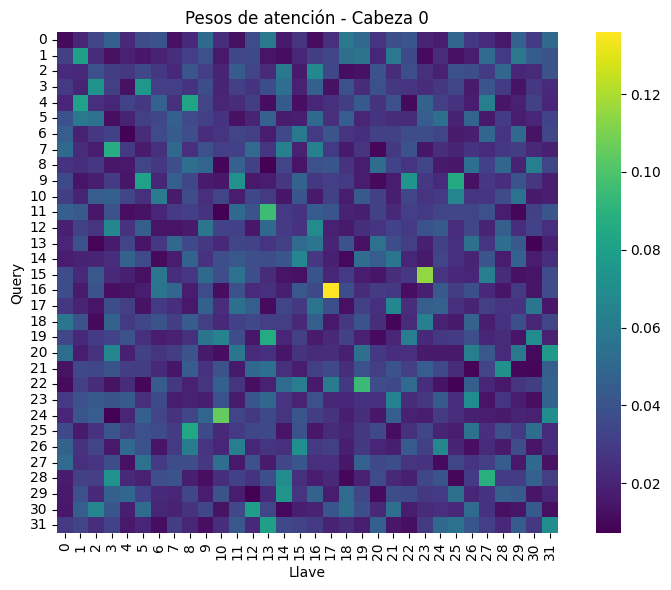

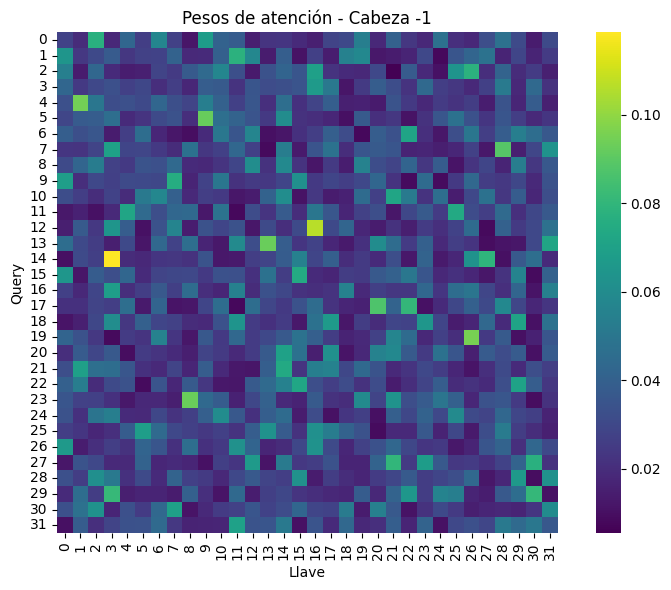

In [9]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(model, input_data):
    """
    Extracts and visualizes attention weights from the encoder layer
    
    Args:
        model: Your RedNeuronal model
        input_data: Input tensor of shape [seq_len, batch, d_model]
    """
    model.eval()
    
    with torch.no_grad():
        attn_weights = []
        
        def hook_fn(module, input, output):
            pass

        attn_output, attn_weights = model.enc_layer.self_attn(
            input_data, 
            input_data, 
            input_data,
            need_weights=True,
            average_attn_weights=False  # Get all heads
        )
        
        return attn_weights

def plot_attention_heads(attn_weights, head_idx=0):
    """
    Plot attention weights for a specific head
    
    Args:
        attn_weights: shape [batch, num_heads, seq_len, seq_len]
        head_idx: which attention head to visualize
    """
    attn = attn_weights[0, head_idx].cpu().numpy()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, cmap='viridis', annot=False, square=True)
    plt.xlabel('Llave')
    plt.ylabel('Query')
    plt.title(f'Pesos de atención - Cabeza {head_idx}')
    plt.tight_layout()
    plt.show()

input_data = torch.randn(32, 1, 16000)  # [seq_len, batch, d_model]
attn_weights = visualize_attention(red_cabrona, input_data)
plot_attention_heads(attn_weights, head_idx=0)
plot_attention_heads(attn_weights, head_idx=-1)

In [ ]:
%%time
# Ya entrena
lr = 0.003
epochs = 3
loss_fun = nn.CrossEntropyLoss()
optim = th.optim.Adam(red_cabrona.parameters(), lr = lr)

for _ in range(epochs):
    print("------Epoch: {}------".format(_+1))
    train_loop(dl, red_cabrona, loss_fun, optim)
print('Acabamos papito.')

------Epoch: 1------
Loss: -0.0. [32/105829]
Loss: -0.0. [3232/105829]
Loss: -0.0. [6432/105829]
Loss: -0.0. [9632/105829]
Loss: -0.0. [12832/105829]
Loss: -0.0. [16032/105829]
Loss: -0.0. [19232/105829]
Loss: -0.0. [22432/105829]
Loss: -0.0. [25632/105829]
Loss: -0.0. [28832/105829]
Loss: -0.0. [32032/105829]
Loss: -0.0. [35232/105829]
Loss: -0.0. [38432/105829]
Loss: -0.0. [41632/105829]


In [ ]:
input_data = torch.randn(32, 1, 16000)  # [seq_len, batch, d_model]
attn_weights = visualize_attention(red_cabrona, input_data)
plot_attention_heads(attn_weights, head_idx=0)
plot_attention_heads(attn_weights, head_idx=-1)

# Ej3: Generación de rostros

# Extra: Generación de texto

La base del código corresponde a la implementación realizada en el notebook oficial del curso [(Github de Gibrán)](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2026-1/notebooks/4a_gpt.ipynb), que a su vez está basado en el modelo NanoGPT. La importación de datos, al ser de un conjunto de datos distinto, es realizada de manera personal.

In [ ]:
import os
import requests

import copy
from itertools import islice
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch as th
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from torchmetrics.text import Perplexity

from torch.utils.tensorboard import SummaryWriter

LR = 1e-3 # tasa de aprendizaje
WD = 1e-4 # weight decay
D_EMBED = 64 # tamaño de los embeddings
D_RDP = 4 * D_EMBED # tamaño de capa oculta de red hacia adelante por posición
N_CABEZAS = 4  # número de cabezas de autoatención
N_CAPAS = 4 # número de bloques Transformers
P_DROPOUT = 0.2 # Probabilidad de dropout

T_CONTEXTO = 32 # tamaño del contexto
MAXSEC = 2000 # tamaño máximo de secuencia ←en generación

T_LOTE = 128
N_EPOCAS = 30
LOGDIR = './logs/'
DC = 'cuda:0' if th.cuda.is_available() else 'cpu'

th.manual_seed(22)
np.random.seed(22)

## Extra.1: Importación de datos

In [ ]:
from collections import Counter

class SpanishDS(Dataset):
    """
    Similar a la clase TinyShakespeare, pero ajustada al conjunto de datos que necesitamos.
    """
    def __init__(self, context_size, path):
        self.path = # AQUÍ VA LA RUTA LOCAL AL DATASET
        self.context_size = context_size
        with open(self.path, 'r', encoding = 'utf-8') as f:
            self.text = f.read()

        self.voc = Counter([c for c in self.text])
        self.voc_size = len(self.voc)

        self.i2c = {i:c for i,(c,f) in enumerate(self.voc.most_common())}
        self.c2i = {c:i for i,(c,f) in enumerate(self.voc.most_common())}